In [1]:
import geopandas as gpd

In [2]:
gdf = gpd.read_file("statePrecinctdif.json")

In [3]:
gdf.head()

,geometry
0,GEOMETRYCOLLECTION (LINESTRING (-78.02763 38.4...


In [8]:
g = gdf.loc[0]["geometry"]

In [9]:
new = gpd.GeoDataFrame(columns=["geometry"])
new

,geometry


In [10]:
counter = 0
for shape in g:
    if counter % 300 == 0:
        print("{}".format((counter/len(g))*100), end="")
    elif counter%50 == 0:
        print("#", end="")
    counter += 1
    
    new = new.append({"geometry": shape}, ignore_index=True)

0.0#####0.8709789803739404#####1.7419579607478808#####2.612936941121821#####3.4839159214957616#####4.354894901869701#####5.225873882243642#####6.096852862617582#####6.967831842991523#####7.8388108233654625#####8.709789803739403#####9.580768784113342#####10.451747764487283#####11.322726744861225#####12.193705725235164#####13.064684705609105#####13.935663685983046#####14.806642666356984#####15.677621646730925#####16.548600627104864#####17.419579607478806#####18.290558587852747#####19.161537568226684#####20.032516548600626#####20.903495528974567#####21.774474509348508#####22.64545348972245#####23.516432470096387#####24.387411450470328#####25.25839043084427#####26.12936941121821#####27.000348391592148#####27.871327371966093#####28.74230635234003#####29.613285332713968#####30.484264313087913#####31.35524329346185#####32.226222273835795#####33.09720125420973#####33.96818023458367#####34.83915921495761#####35.71013819533155#####36.581117175705494#####37.452096156079435#####38.32307513645337##

In [11]:
new.head()

,geometry
0,"LINESTRING (-78.02763 38.47857, -78.02763 38.4..."
1,"LINESTRING (-79.27283 37.84790, -79.27365 37.8..."
2,"LINESTRING (-80.47560 37.42295, -80.47560 37.4..."
3,"POLYGON ((-82.13715 36.63294, -82.13481 36.634..."
4,"POLYGON ((-82.13368 36.63603, -82.13359 36.636..."


In [12]:
new.to_file("stateDifFixed.json", driver="GeoJSON")

# delete all non polygon shapes

In [15]:
new["index"] = 0
new["id"] = ""

In [17]:
types = ["MultiPolygon", "Polygon"]
for index, row in new.iterrows():
    if row["geometry"].geom_type not in types:
        new.drop(index=index, inplace=True)
        print("#", end="")
new.head(2)

###

,geometry,index,id
3,"POLYGON ((-82.13715 36.63294, -82.13481 36.634...",0,
4,"POLYGON ((-82.13368 36.63603, -82.13359 36.636...",0,


In [18]:
copy = new.copy()

# filter by area

In [22]:
# dif.to_file("RI_Ghost.json", driver="GeoJSON")
new.crs = "EPSG:4326"

In [23]:
new = new.to_crs("EPSG:3857")

In [25]:
a = 3716.1216
new["filtered"] = ""
for index, row in new.iterrows():
    if row.geometry.geom_type == "MultiPolygon":
        m = MultiPolygon([shape for shape in row["geometry"] if shape.area >= a])
        if m.is_empty:
            new.drop(index, inplace=True)
        else:
            new.at[index, "filtered"] = m
    else:
        if row["geometry"].area < a:
            new.drop(index, inplace=True)
        else:
            new.at[index, "filtered"] = row["geometry"]

In [26]:
new.set_geometry("filtered", drop=True, inplace=True)

In [27]:
new = new.to_crs("EPSG:4326")

# turn all multipolygon into polygon

In [30]:
newgdf = gpd.GeoDataFrame(crs="EPSG:4326")
newgdf["geometry"] = ""
newgdf["index"] = 0

In [31]:
i = 0
for index, row in new.iterrows():
    g = row["geometry"]
    if g.geom_type == "MultiPolygon":
        for shape in g:
            newgdf.at[i, "geometry"] = shape
            newgdf.at[i, "index"] = i
            i += 1
    else:
        newgdf.at[i, "geometry"] = g
        newgdf.at[i, "index"] = i
        i += 1
newgdf.set_geometry("geometry", inplace=True)

In [32]:
newgdf.head(1)

,geometry,index
0,"POLYGON ((-82.13715 36.63294, -82.13481 36.634...",0.0


In [33]:
print(len(new), len(newgdf))

2596 2596


# drop precincts that is fully inside stateDif
- stateDif is the difference between og state and state buffered by 200feet

In [34]:
stateDif = gpd.read_file("stateDif.json")

In [35]:
for index, row in stateDif.iterrows():
    index_drop = newgdf[newgdf["geometry"].within(stateDif.loc[index]["geometry"])].index.to_list()
    for i in index_drop:
        newgdf.drop(index=i, inplace=True)
        print("#", end="")

# create key for ghost table

In [36]:
newgdf.head(2)

,geometry,index
0,"POLYGON ((-82.13715 36.63294, -82.13481 36.634...",0.0
1,"POLYGON ((-82.12232 36.65820, -82.12189 36.658...",1.0


In [37]:
newgdf["id"] = ""
i = 0
for index, row in newgdf.iterrows():
    newgdf.at[index, "id"] = "va-ghost-" + str(i)
    i += 1
newgdf.head(2)

,geometry,index,id
0,"POLYGON ((-82.13715 36.63294, -82.13481 36.634...",0.0,va-ghost-0
1,"POLYGON ((-82.12232 36.65820, -82.12189 36.658...",1.0,va-ghost-1


In [38]:
newgdf.to_file("VA_Ghost.json", driver="GeoJSON")

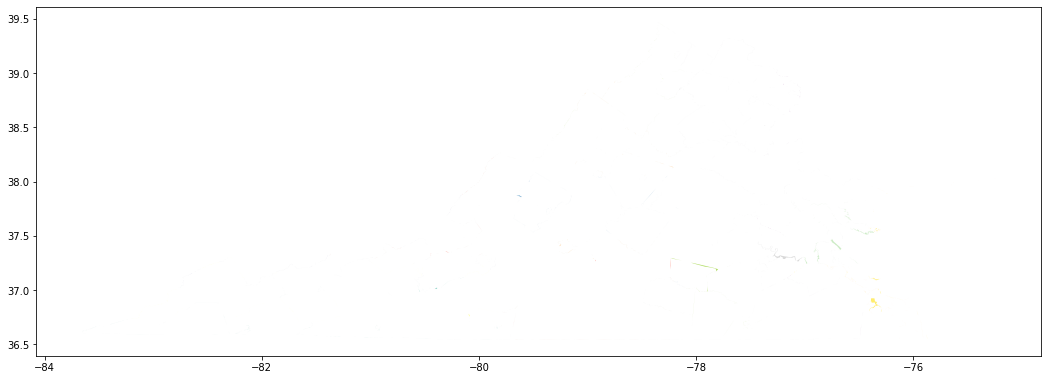

In [39]:
newgdf.plot(figsize=(18, 13), cmap="Set3")